In [69]:
import datetime
import glob

import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
from minio import Minio
import sweetviz as sv

import warnings
warnings.filterwarnings("ignore")

mpl.style.use("fivethirtyeight")
mpl.rcParams["figure.figsize"] = (15, 8)
mpl.rcParams["figure.dpi"] = 50
mpl.rcParams["lines.linewidth"] = 2
mpl.rcParams["font.size"] = 12
mpl.rcParams["figure.titlesize"] = 25

In [43]:
# --------------------------------------------------------------
# Connecting to Data Lake
# --------------------------------------------------------------

client = Minio(
    "localhost:9000", access_key="minioadmin", secret_key="minioadmin", secure=False
)

In [44]:
# --------------------------------------------------------------
# Downloading Dataset from Data Lake
# --------------------------------------------------------------

client.fget_object(
    "processing",
    "employees_dataset.parquet",
    "temp_.parquet",
)
df = pd.read_parquet("temp_.parquet")

# Organization of the dataset
df = df[
    [
        "department",
        "salary",
        "mean_work_last_3_months",
        "number_projects",
        "satisfaction_level",
        "last_evaluation",
        "time_in_company",
        "work_accident",
        "left",
    ]
]

df.head()

,department,salary,mean_work_last_3_months,number_projects,satisfaction_level,last_evaluation,time_in_company,work_accident,left
0,sales,low,266.000000,2.0,38.0,53.0,3.0,0.0,1.0
1,sales,medium,252.000000,5.0,80.0,86.0,6.0,0.0,1.0
2,sales,medium,289.666667,7.0,11.0,88.0,4.0,0.0,1.0
3,sales,low,275.666667,5.0,72.0,87.0,5.0,0.0,1.0
4,sales,low,292.333333,2.0,37.0,52.0,3.0,0.0,1.0


#### Sweetviz
***

**Sweetviz** is a Python library that automates the process of data exploration. It generates detailed and easy-to-interpret visual and statistical reports to quickly understand and compare datasets, helping to identify patterns, correlations, and trends in the data.

Utilizing Sweetviz for initial data exploration enhances insights by automating comprehensive visualizations and statistical analysis.

In [67]:
my_report = sv.analyze(df,"turnover")
my_report.show_html()

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:01 -> (00:00 left)


Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [45]:
# --------------------------------------------------------------
# Verify missing values
# --------------------------------------------------------------

# Verification of missing values
df.isnull().sum()

department                 1
salary                     1
mean_work_last_3_months    0
number_projects            1
satisfaction_level         1
last_evaluation            1
time_in_company            1
work_accident              1
left                       1
dtype: int64

In [46]:
# Drop all the missing values (just one sample)
df.dropna(inplace=True)

df.isnull().sum()

department                 0
salary                     0
mean_work_last_3_months    0
number_projects            0
satisfaction_level         0
last_evaluation            0
time_in_company            0
work_accident              0
left                       0
dtype: int64

In [47]:
# --------------------------------------------------------------
# Change the type of the columns
# --------------------------------------------------------------

df["number_projects"] = df["number_projects"].astype(int)
df["mean_work_last_3_months"] = df["mean_work_last_3_months"].astype(int)
df["time_in_company"] = df["time_in_company"].astype(int)
df["work_accident"] = df["work_accident"].astype(int)
df["left"] = df["left"].astype(int)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14999 entries, 0 to 14998
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   department               14999 non-null  object 
 1   salary                   14999 non-null  object 
 2   mean_work_last_3_months  14999 non-null  int32  
 3   number_projects          14999 non-null  int32  
 4   satisfaction_level       14999 non-null  float64
 5   last_evaluation          14999 non-null  float64
 6   time_in_company          14999 non-null  int32  
 7   work_accident            14999 non-null  int32  
 8   left                     14999 non-null  int32  
dtypes: float64(2), int32(5), object(2)
memory usage: 878.8+ KB


In [48]:
# --------------------------------------------------------------
# Renames the columns
# --------------------------------------------------------------

df = df.rename(
    columns={
        "satisfaction_level": "satisfaction",
        "last_evaluation": "evaluation",
        "number_projects": "projectCount",
        "mean_work_last_3_months": "averageMonthlyHours",
        "time_in_company": "yearsAtCompany",
        "work_accident": "workAccident",
        "left": "turnover",
    }
)

df.head()

,department,salary,averageMonthlyHours,projectCount,satisfaction,evaluation,yearsAtCompany,workAccident,turnover
0,sales,low,266,2,38.0,53.0,3,0,1
1,sales,medium,252,5,80.0,86.0,6,0,1
2,sales,medium,289,7,11.0,88.0,4,0,1
3,sales,low,275,5,72.0,87.0,5,0,1
4,sales,low,292,2,37.0,52.0,3,0,1


In [49]:
#---------------------------------------------------------------
# Calculating the turnover rate
# --------------------------------------------------------------

df.describe()

turnover_rate = df["turnover"].value_counts() / len(df)
turnover_rate



0    0.761917
1    0.238083
Name: turnover, dtype: float64

In [50]:
# --------------------------------------------------------------
# Turnover statistics overview
# --------------------------------------------------------------

df.groupby("turnover").mean(numeric_only=True).round(2)

,averageMonthlyHours,projectCount,satisfaction,evaluation,yearsAtCompany,workAccident
turnover,,,,,,
0,275.67,3.79,64.89,71.59,3.40,0.16
1,275.74,3.83,49.74,71.69,3.81,0.09


The dataset comprises:

- 14,998 employee observations and 9 attributes.
- The company has a turnover rate of 24%.
- The average employee satisfaction is 64.
- The average employee satisfaction of those who left the company is 49.

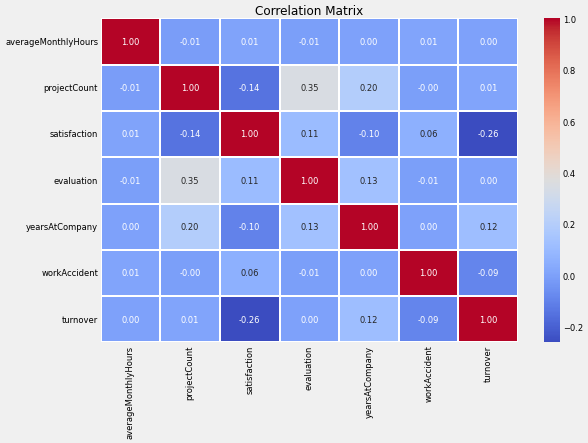

In [51]:
# --------------------------------------------------------------
# Calculating the correlation matrix
# --------------------------------------------------------------

corr = df.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

#### ***Correlation Matrix & Heatmap***
---
**Attributes with moderate positive correlation:**
- projectCount vs evaluation: 0.34 (weak/moderate)
- yearsCompany vs projectCount: 0.19 (weake)

**Attributes with moderate negative correlation:**
- satisfaction vs turnover: -0.21 (weak)

**Questions:**
- Which attributes impact our target variable (turnover)?
- Are there attributes with high correlation between them?
- How can we delve deeper to understand the correlations?

**Summary:**

There is a **positive correlation** between the projectCount and Evaluation attributes.

It makes sense that employees who are involved in more projects tend to work more and have better evaluations.

There is a **negative correlation** between the satisfaction and turnover attributes.

We can assume that employees who leave the company more are less satisfied.m

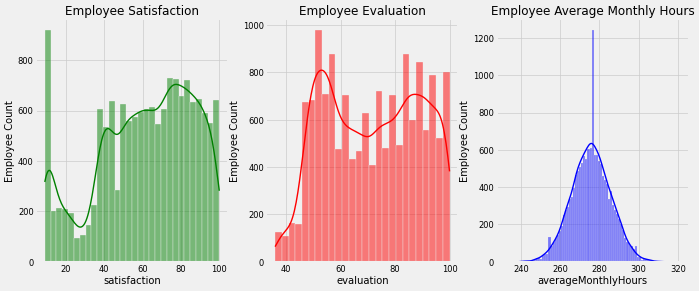

In [52]:
# --------------------------------------------------------------
# Calculating attribute distributions.
# --------------------------------------------------------------

fig, axes = plt.subplots(ncols=3, figsize=(15, 6))

sns.histplot(data=df, x="satisfaction", kde=True, color="g", ax=axes[0]).set_title(
    "Employee Satisfaction"
)
axes[0].set_ylabel("Employee Count")

sns.histplot(data=df, x="evaluation", kde=True, color="r", ax=axes[1]).set_title(
    "Employee Evaluation"
)
axes[1].set_ylabel("Employee Count")

sns.histplot(
    data=df, x="averageMonthlyHours", kde=True, color="b", ax=axes[2]
).set_title("Employee Average Monthly Hours")
axes[2].set_ylabel("Employee Count")
plt.show()


#### Distributions (Satisfaction - Evaluation - AverageMonthlyHours)
***
**Summary:** Examining the distribution of some attributes in the dataset:
 - **Satisfaction** - There's a peak of employees with low satisfaction, but the highest concentration is in the range of 60 to 80.
 - **Evaluation** - We have a bimodal distribution of employees with low evaluations, less than 60, and high evaluations, greater than 80.
 - **AverageMonthlyHours** - The concentration of the number of hours worked in the last 3 months is around the mean at 275 hours.

**Questions:**
 - Is there a reason for the peak of unsatisfied employees?

Checking the turnover of salary.

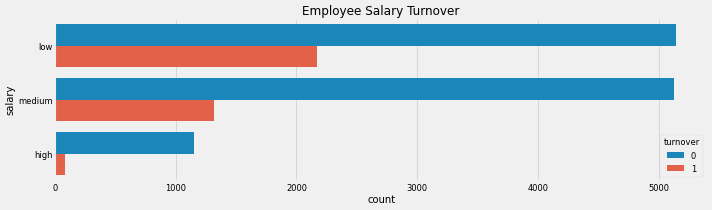

In [53]:
# --------------------------------------------------------------
# Checking the turnover based o salary
# --------------------------------------------------------------

f, ax = plt.subplots(figsize=(15, 4))
sns.countplot(y="salary", hue="turnover", data=df).set_title("Employee Salary Turnover");


#### Salary V.S. Turnover
***
**Summary:**
 - Most of the employees who left had **low** or **medium** salaries.
 - Very few employees with high salaries left the company.

**Questions:**
 - What's the work environment like? Does it differ by salary?
 - What prompts employees with high salaries to leave the company?

Text(0.5, 1.0, 'Departament vs Turnover')

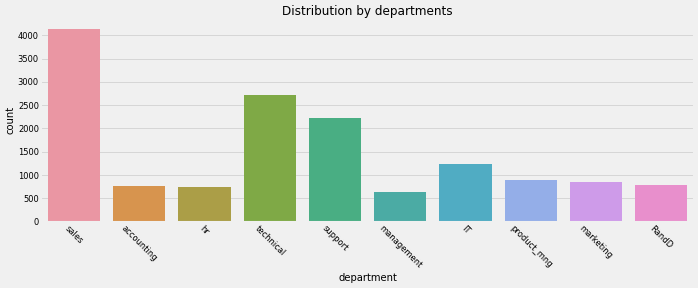

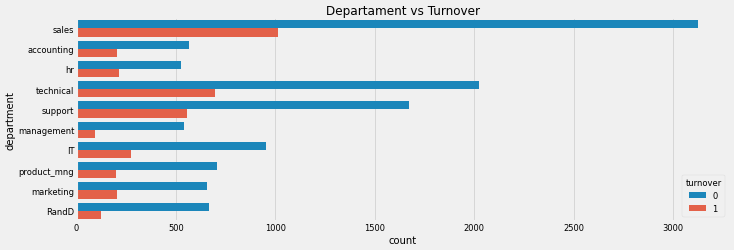

In [54]:
# --------------------------------------------------------------
# Checking the turnover in relation to department
# --------------------------------------------------------------

f, ax = plt.subplots(figsize=(15, 5))

plt.xticks(rotation=-45)
sns.countplot(x="department", data=df).set_title("Distribution by departments")

f, ax = plt.subplots(figsize=(15, 5))
sns.countplot(y="department", hue="turnover", data=df).set_title(
    "Departament vs Turnover"
)

In [55]:
# Group by "department" and calculate the percentage of turnover (1)
department_turnover_percentage = (
    df[df["turnover"] == 1].groupby("department")["turnover"].sum()
    / df.groupby("department")["turnover"].count()
    * 100
).sort_values(ascending=False)

department_turnover_percentage

department
hr             29.093369
accounting     26.597132
technical      25.625000
support        24.899058
sales          24.492754
marketing      23.659674
IT             22.249389
product_mng    21.951220
RandD          15.374841
management     14.444444
Name: turnover, dtype: float64


#### Department V.S. Turnover
***
**Summary:** Let's explore more insights regarding the company's departments.
- The top 3 departments with the highest turnover rates are Sales, Technical, and Support.
- The Management department has the lowest turnover volume.
- The HR department has the highest percentage of turnover.

**Questions:**
- Could delving deeper into the departments with high and low turnover rates provide us with more significant insights?
- What are the salary levels within these departments?


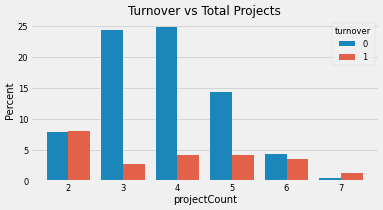

In [56]:
# --------------------------------------------------------------
# Checking the turnover in relation to the number of projects.
# --------------------------------------------------------------

fig = plt.figure(
    figsize=(8, 4),
)
ax = sns.barplot(
    x="projectCount",
    y="projectCount",
    hue="turnover",
    data=df,
    estimator=lambda x: len(x) / len(df) * 100,
)
ax.set(ylabel="Percent")
plt.title("Turnover vs Total Projects")
plt.plot();

#### Turnover V.S. ProjectCount
***
**Summary:** Interesting insights we've found here:
- More than half of employees with **2, 6, and 7 projects** left the company.
- The majority of employees who remain with the company are involved in **3 to 5 projects**.
- All employees involved in **7 projects** left the company.
- There's a slight **trend of increasing turnover rate** as the number of projects increases.

**Questions:**
- Why are employees leaving the company in relation to the number of projects?
- Does it make sense to consider that employees involved in 2 or fewer projects are demotivated and thus leaving the company?
- Could employees involved in more than 6 projects feel overwhelmed and that's why they leave the company?m

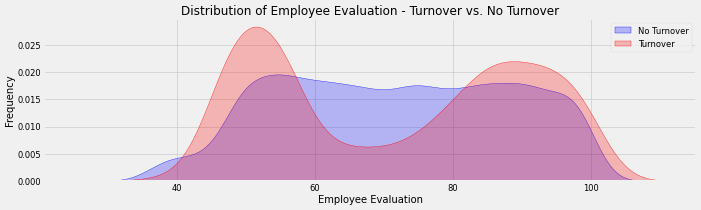

In [57]:
# --------------------------------------------------------------
# Checking the turnover in relation to the evaluation note
# --------------------------------------------------------------

fig = plt.figure(figsize=(15, 4))
ax = sns.kdeplot(
    df.loc[df["turnover"] == 0, "evaluation"], color="b", fill=True, label="No Turnover"
)
ax = sns.kdeplot(
    df.loc[df["turnover"] == 1, "evaluation"], color="r", fill=True, label="Turnover"
)
ax.set(xlabel="Employee Evaluation", ylabel="Frequency")
plt.title("Distribution of Employee Evaluation - Turnover vs. No Turnover")
plt.legend()
plt.plot();


#### Turnover V.S. Evaluation
***
**Summary:**
 - We have a bimodal distribution for the group that left the company.
 - Employees with **low performance** tend to leave the company.
 - Employees with **high performance** tend to leave the company.
 - The **optimal point** for employees who stayed is within the evaluation range of 60 to 80.m

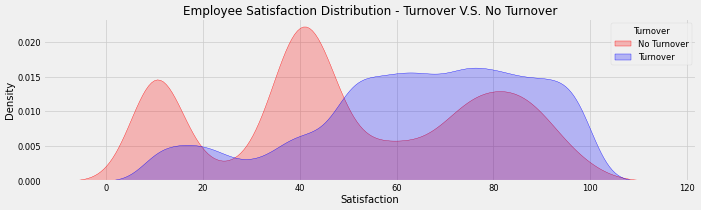

In [58]:
# --------------------------------------------------------------
# Verifying the turnover regarding employee satisfaction.
# --------------------------------------------------------------

plt.figure(figsize=(15, 4))
sns.kdeplot(
    data=df,
    x="satisfaction",
    hue="turnover",
    common_norm=False,
    palette=["b", "r"],
    fill=True,
)
plt.title("Employee Satisfaction Distribution - Turnover V.S. No Turnover")
plt.xlabel("Satisfaction")
plt.ylabel("Density")
plt.legend(title="Turnover", labels=["No Turnover", "Turnover"])
plt.show()

#### Turnover V.S. Satisfaction
***
**Summary:**
- Employees with a satisfaction level of 20 or less tend to leave the company.
- Employees with a satisfaction level up to 50 have a higher probability of leaving the company.


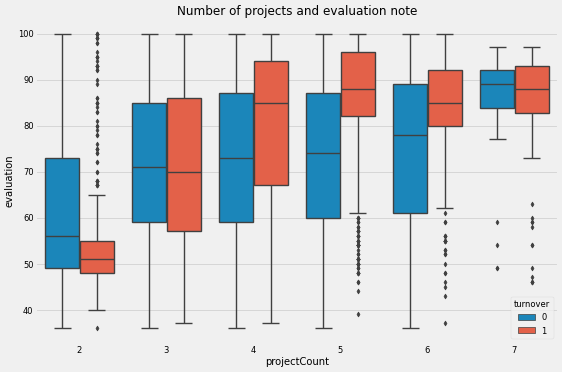

In [59]:
#--------------------------------------------------------------
# Checking the relationship between number of projects and the
# employee's evaluation note
# --------------------------------------------------------------

fig = plt.figure(figsize=(12, 8))
sns.boxplot(x="projectCount", y="evaluation", hue="turnover", data=df)
plt.title("Number of projects and evaluation note")
plt.show()

In [60]:
# Grouping the data and calculating mean evaluation scores
grouped_data = df.groupby(["projectCount", "turnover"]).evaluation.mean().reset_index()
grouped_data

,projectCount,turnover,evaluation
0,2,0,61.193548
1,2,1,52.622314
2,3,0,71.709907
3,3,1,71.177057
4,4,0,72.988746
5,4,1,79.968404
6,5,0,73.495579
7,5,1,85.700980
8,6,0,73.837713
9,6,1,84.569260


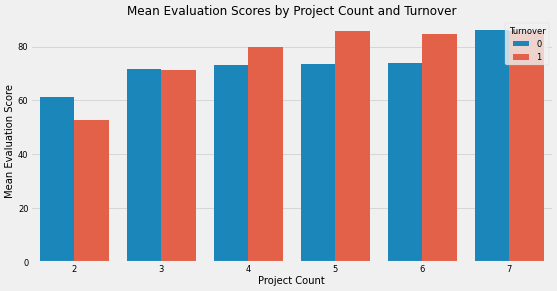

In [61]:
# Plotting the data using a bar graph
plt.figure(figsize=(12, 6))
sns.barplot(x="projectCount", y="evaluation", hue="turnover", data=grouped_data)
plt.title("Mean Evaluation Scores by Project Count and Turnover")
plt.xlabel("Project Count")
plt.ylabel("Mean Evaluation Score")
plt.legend(title="Turnover", loc="upper right")
plt.show()

#### ProjectCount VS Evaluation
***
**Summary:**
- There is an **increase in evaluation scores** for employees who completed more projects within the group that left the company.
- For the group of people who remained in the company, employees had a **consistent evaluation score**, despite the increase in project counts.
- Employees who stayed in the company had an **average evaluation score around 70%**, even as the number of projects increased.
- This relationship changes drastically among employees who left the company. From 3 projects onwards, **average evaluation scores increase significantly**.
- Employees with **two projects and poor evaluation scores** left.
- Employees with **more than 3 projects and high evaluation scores** left.

**Questions:**
- Why did the employees who left have, on average, higher evaluation scores than employees who stayed, even with an increase in the number of projects?
- Shouldn't employees with lower evaluation scores have a tendency to leave the company more?

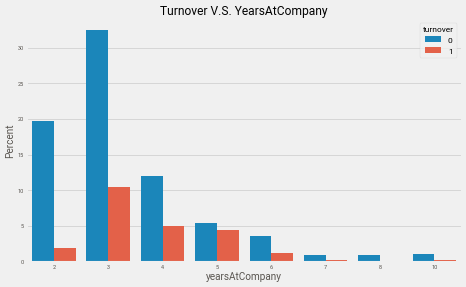

In [70]:
# --------------------------------------------------------------
# Checking the relationship between company time and turnover
# --------------------------------------------------------------

fig = plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x="yearsAtCompany",
    y="yearsAtCompany",
    hue="turnover",
    data=df,
    estimator=lambda x: len(x) / len(df) * 100,
)
ax.set(ylabel="Percent")
plt.title("Turnover V.S. YearsAtCompany")
plt.show()

##### Turnover V.S. YearsAtCompany
***
**Summary:** Let's delve further into the reasons why employees are leaving the company.
 - Employees with **4 and 5 years of tenure** have left the company.
 - Employees with **more than 5 years of tenure** need further examination.
 
**Questions:**
  - Why are employees leaving primarily in the 3-5 years range?
  - Who are these employees who have left?


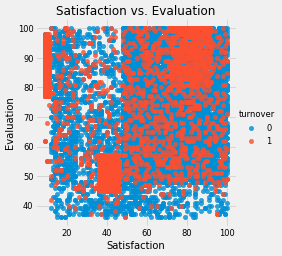

In [62]:
# --------------------------------------------------------------
# Checking the relationship between employee satisfaction and
# its assessment.
# --------------------------------------------------------------

sns.lmplot(x="satisfaction", y="evaluation", data=df, fit_reg=False, hue="turnover")
plt.title("Satisfaction vs. Evaluation")
plt.xlabel("Satisfaction")
plt.ylabel("Evaluation")
plt.show()

#### Satisfaction VS Evaluation
***
**Summary**: This analysis reveals three distinct employee clusters.

**Cluster 1 (Unhappy and Hardworking Employees):** This group shows low satisfaction scores below 20 combined with high evaluations above 75. It suggests that employees who left the company were skilled workers but experienced dissatisfaction at work.

**Cluster 2 (Poor and Unhappy Employees):** With satisfaction levels ranging from 35 to 50 and evaluations below approximately 58, this cluster might represent employees who received poor evaluations and felt dissatisfied in their roles.

**Cluster 3 (Satisfied and Hardworking Employees):** Characterized by satisfaction scores between 75 and 90 and evaluations exceeding 80, this cluster likely comprises "ideal" employees who enjoyed their work and received high performance evaluations.

These findings raise important questions such as the potential causes of dissatisfaction among highly evaluated employees, the impact of workload on employee well-being, and the possibility of more complex clustering patterns beyond the three identified groups.


**Códigos orignais:** [visualize.py](../src/visualization/visualize.py)

**Arquivo salvo em:** (../data/interim/01_cleaned_data.pkl)

**Next step:** [03_build_features.ipynb](03_build_features.ipynb)